# Prerequisites

In [1]:
import os
import sys

sys.path.append("..")

In [2]:
%load_ext autoreload
%autoreload 2

import argparse
import json
import os
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
from IPython.display import display
from matplotlib.patches import Rectangle
from monai import losses
from monai.networks import nets
from scipy.ndimage import binary_erosion
from skimage import measure
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm

from BugNIST_metric import all_scores, score
from dataset3d import BNSetMix, get_dloader_noise
from util3d import get_obj_score3d, get_saliency3d, show_volume

In [3]:
# Random seed
seed = 191510

data_dir = "/work3/s191510/data/BugNIST_DATA"
name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}
class_names = list(name_legend.keys())

model_types = {
    "r18": "ResNet 18",
}


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    model = nets.UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=len(name_legend) + 1,  # Bug classes and background
        channels=(32, 64, 128, 256),
        strides=(2, 2, 2),
        num_res_units=2,
    )

    model.to(device)
    return model

# Model

In [4]:
model_dir = "../models/bn-seg-checkpoints"

# Individual bugs
# run_dir = f"{model_dir}/run-20240607-112444"
# cpt_path = f"{run_dir}/cpts/r18_e160_best.cpt"

# Synthetic mixtures
run_dir = f"{model_dir}/run-synth"
cpt_path = f"{run_dir}/cpts/r18_e75_best.cpt"

with open(f"{run_dir}/config.json", "r") as f:
    config = json.load(f)
config

{'lr': 0.0001,
 'wd': 0.0,
 'batch_size': 16,
 'epochs': 80,
 'model_type': 'r18',
 'lr_step': 40,
 'perlin': True,
 'synth': True,
 'num_workers': 16,
 'save_every': 10,
 'wandb': True}

In [5]:
model = get_model("")
checkpoint = torch.load(cpt_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
del checkpoint

# Evaluation on test set
The default values in the `seg_to_bbox` should be equivalent to those from the original BugNIST paper.

In [6]:
def seg_to_bbox(out, conf_threshold=0.5, n_erode=0, min_size=125):
    """From the bugnist kaggle challenge notebook: https://www.kaggle.com/code/patmjen/u-net-baseline"""

    pred_sm = out.softmax(dim=1).cpu().detach().numpy()
    class_props = []
    for i in range(1, 13):
        if n_erode > 0:
            props = measure.regionprops(
                measure.label(
                    binary_erosion(pred_sm[0, i] > conf_threshold, iterations=n_erode)
                )
            )
        else:
            props = measure.regionprops(measure.label(pred_sm[0, i] > conf_threshold))
        props = list(filter(lambda p: p.area > min_size, props))
        class_props.append(props)

    boxes = np.array([p.bbox for props in class_props for p in props])
    centers = np.array([p.centroid for props in class_props for p in props])
    labels = np.array([i + 1 for i, props in enumerate(class_props) for p in props])
    scores = np.ones(len(boxes))
    return {
        "boxes": boxes,
        "centers": centers,
        "labels": labels,
        "scores": scores,
        "pred": pred_sm,
    }


def pack_prediction(centers, labels):
    """From the bugnist kaggle challenge notebook: https://www.kaggle.com/code/patmjen/u-net-baseline"""
    centers = centers - np.array([[0, 18, 18]])
    strings = []
    for l, c in zip(labels, centers):
        strings.append(f"{l};{c[2]};{c[1]};{c[0]}")
    return ";".join(strings)

In [7]:
test = pd.read_csv("../data/BugNIST_DATA/test/test.csv", index_col=0)
# test.head()

In [8]:
mixset = BNSetMix("../data/BugNIST_DATA/test")

# Unit tests

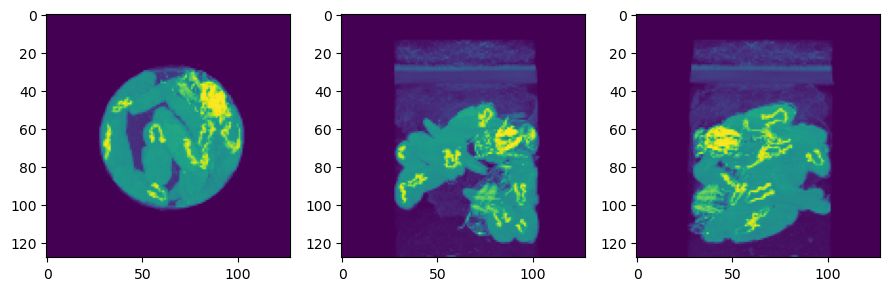

torch.Size([1, 128, 128, 128])

In [9]:
# Check that everything loads correctly
idx = 0
volume = mixset[idx][0]
volume = volume[:, :, 14:-14, 14:-14]
show_volume(volume, size=3)
volume.size()

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

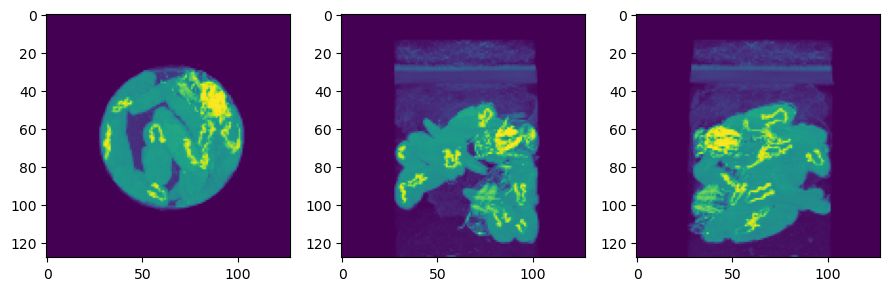

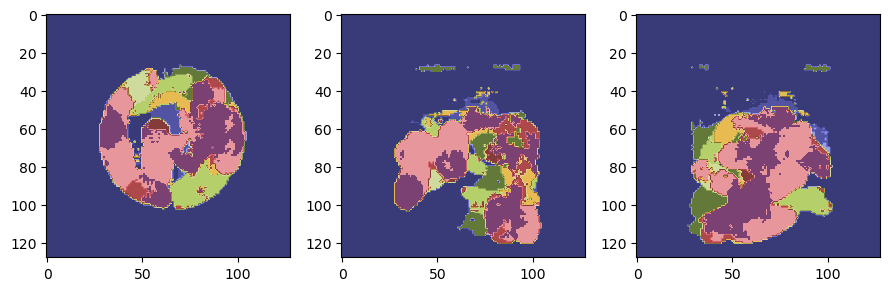

In [11]:
# conf_t = 0.5
model.to(device)
with torch.no_grad():
    out = model(volume.unsqueeze(0).to(device)).cpu()

pred = torch.softmax(out.detach(), dim=1)
scores, indices = pred.max(1)
# indices[scores < conf_t] = 0

show_volume(volume, size=3)
show_volume(indices, size=3, cmap="tab20b", vmax=len(class_names) + 1)

C:\Users\runes\AppData\Local\Temp\ipykernel_87648\3916258604.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  val_string = test.loc[fname][0]


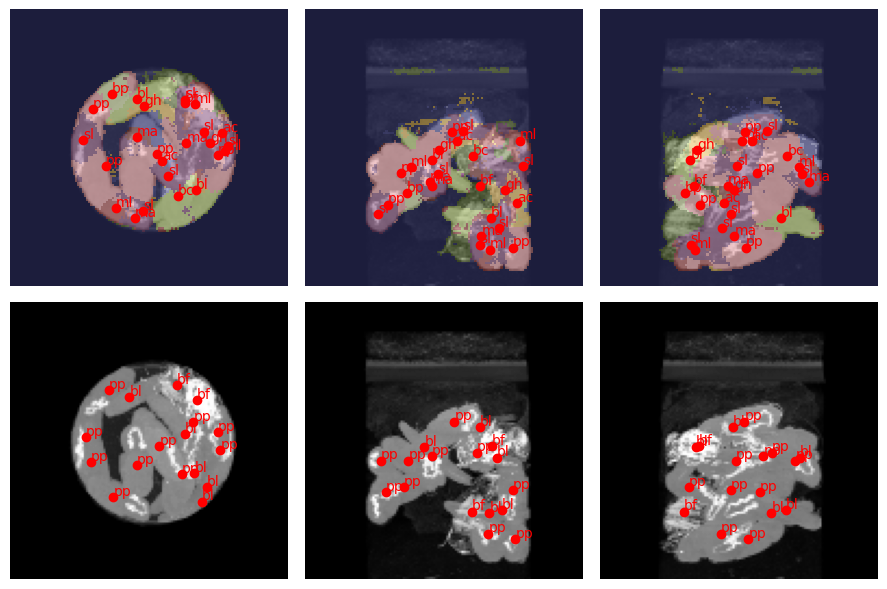

In [12]:
pred = seg_to_bbox(out)

fname = os.path.basename(mixset.volumes[idx])
val_string = test.loc[fname][0]
true_labels = val_string.split(";")[::4]
true_centers = np.array(
    [
        [float(x) for x in val_string.split(";")[1::4]],
        [float(x) for x in val_string.split(";")[2::4]],
        [float(x) for x in val_string.split(";")[3::4]],
    ]
).T

true_centers = true_centers[:, [2, 1, 0]]
true_centers += np.array([[0, 18, 18]])


fig, (axs0, axs1) = plt.subplots(2, 3, figsize=(9, 6), tight_layout=True)
for a in range(3):
    ax = axs0[a]

    # fig, ax = plt.subplots(figsize=(10, 10))

    ax.imshow(volume[0].numpy().max(axis=a), cmap="gray")
    ax.imshow(
        pred["pred"][0].argmax(axis=0).max(axis=a),
        alpha=0.5,
        interpolation="none",
        cmap="tab20b",
        vmax=len(class_names) + 1,
    )
    for box, center, label in zip(pred["boxes"], pred["centers"], pred["labels"]):
        if a == 0:
            center = (center[2] - 0.5, center[1] - 0.5)
            xy = (box[2] - 0.5, box[1] - 0.5)
            height = box[4] - box[1]
            width = box[5] - box[2]
        elif a == 1:
            center = (center[2] - 0.5, center[0] - 0.5)
            xy = (box[2] - 0.5, box[0] - 0.5)
            height = box[3] - box[0]
            width = box[5] - box[2]
        else:
            center = (center[1] - 0.5, center[0] - 0.5)
            xy = (box[1] - 0.5, box[0] - 0.5)
            height = box[3] - box[0]
            width = box[4] - box[1]
        # ax.add_patch(Rectangle(xy, width, height, edgecolor="r", facecolor="none"))
        ax.plot(center[0], center[1], "ro")
        # ax.text(xy[0], xy[1] - 1, class_names[label - 1], color="r")
        ax.text(center[0], center[1] - 1, class_names[label - 1], color="r")
    ax.axis("off")

# fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)
for a in range(3):
    ax = axs1[a]

    ax.imshow(volume[0].numpy().max(axis=a), cmap="gray")
    for center, label in zip(true_centers, true_labels):
        if a == 0:
            center = (center[2] - 0.5, center[1] - 0.5)
        elif a == 1:
            center = (center[2] - 0.5, center[0] - 0.5)
        else:
            center = (center[1] - 0.5, center[0] - 0.5)
        ax.plot(center[0], center[1], "ro")
        ax.text(center[0], center[1] - 1, label, color="r")
    ax.axis("off")

# Evaluate

In [13]:
sanitize = True

if sanitize:
    conf_t = 0.8
    n_erode = 1
else:
    conf_t = 0.5
    n_erode = 0

device = "cuda"
submission = {
    "filename": [],
    "centerpoints": [],
}

model.to(device)
model.eval()
for idx in tqdm(range(len(mixset))):
    volume = mixset[idx][0]
    volume = volume[:, :, 14:-14, 14:-14]
    with torch.no_grad():
        out = model(volume.unsqueeze(0).to(device)).cpu()

    pred = seg_to_bbox(out, conf_threshold=conf_t, n_erode=n_erode)
    # pred = predict(torch.tensor(image[None, None]).float().cuda())
    pred_text_labels = [class_names[l - 1].lower() for l in pred["labels"]]
    pred_text = pack_prediction(pred["centers"].reshape(pred["centers"].shape[0], 3), pred_text_labels)
    submission["filename"].append(os.path.basename(mixset.volumes[idx]))
    submission["centerpoints"].append(pred_text)
submission = pd.DataFrame(submission)
submission.set_index("filename", inplace=True)

# f1_mean = score(validation.reset_index(), submission.reset_index())
# print(f"F1 score: {f1_mean:.3f}")

  0%|          | 0/310 [00:00<?, ?it/s]

In [14]:
test.sort_index(inplace=True)
# display(submission.head())
# display(test.head())

In [15]:
scores = all_scores(test.reset_index(), submission.reset_index())

scores_unpack = {
    "f1_detect": [],
    "f1_class": [],
    "precision_detect": [],
    "precision_class": [],
    "recall_detect": [],
    "recall_class": [],
}
for (
    f1_detect,
    precision_detect,
    recall_detect,
    f1_classes,
    precision_classes,
    recall_classes,
) in scores:
    scores_unpack["f1_detect"].append(f1_detect)
    scores_unpack["f1_class"].append(f1_classes)
    scores_unpack["precision_detect"].append(precision_detect)
    scores_unpack["precision_class"].append(precision_classes)
    scores_unpack["recall_detect"].append(recall_detect)
    scores_unpack["recall_class"].append(recall_classes)

scores_df = pd.DataFrame.from_dict(scores_unpack)
scores_df.head()

,f1_detect,f1_class,precision_detect,precision_class,recall_detect,recall_class
0,0.785714,0.500000,1.000,0.636364,0.647059,0.411765
1,0.857142,0.761904,1.000,0.888889,0.750000,0.666667
2,0.933333,0.800000,0.875,0.750000,1.000000,0.857143
3,0.540540,0.108108,1.000,0.200000,0.370370,0.074074
4,0.769230,0.307692,1.000,0.400000,0.625000,0.250000


In [16]:
mean_scores = scores_df.mean()
se_scores = scores_df.std() / np.sqrt(len(scores_df))
pd.DataFrame.from_dict(
    {
        "Mean": mean_scores,
        "Standard Error": se_scores,
        "CI (SE * 1.96)": se_scores * 1.96,
    }
).round(3)

,Mean,Standard Error,CI (SE * 1.96)
f1_detect,0.812,0.008,0.016
f1_class,0.491,0.011,0.021
precision_detect,0.974,0.004,0.009
precision_class,0.584,0.012,0.023
recall_detect,0.732,0.012,0.023
recall_class,0.446,0.012,0.023
